## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

# Task 1: Create a classifier

The first attempt for this task was based on a multi-label strategy. I have kept some of the code for that in the notebook. However, there were several issues with that approach. The biggest one being the system not being able to form a very good decision boundary as a result everything started getting classified into a general category.

The second approach is based on a conventional multiclass classifier. However, this also resulted in very low accuracy and unreliable results.

The third approach is based binary classification of 
* diabetic retinopathy vs normal
* glaucoma vs normal
* other vs normal

The reason for this is that all of these ailments look at different parts of retina. So by changing preprocessing we are able to focus at different sections of the scan and make more accurate predictions.

In [1]:
# importing the required modules
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import gradients, mean

from sklearn.model_selection import train_test_split

In [2]:
# find path for the data
data_path = 'Data'

### Process the Training Data

In [4]:
# read the training labels
train_labels = pd.read_csv(os.path.join(data_path, 'train/train.csv'))
train_labels.set_index('filename', inplace=True)
train_labels.head()

,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
filename,,,,,,,
c24a1b14d253.jpg,0,0,0,0,0,1,0
9ee905a41651.jpg,0,0,0,0,0,1,0
3f58d128caf6.jpg,0,0,1,0,0,0,0
4ce6599e7b20.jpg,1,0,0,0,1,0,0
0def470360e4.jpg,1,0,0,0,1,0,0


### Create Data Pipelines

In [4]:
# direcotries containing files
normal_dir = 'Data/separated_pics_train/normal'
glaucoma_dir = 'Data/separated_pics_train/glaucoma'
dbr_dir = 'Data/separated_pics_train/diabetic retinopathy'
other_dir = 'Data/separated_pics_train/other'

In [ ]:
# move files to new directories
#shutil.copytree(normal_dir, 'Data/norm vs dbr/normal')
#shutil.copytree(dbr_dir, 'Data/norm vs dbr/dbr')

#shutil.copytree(normal_dir, 'Data/norm vs glc/normal')
#shutil.copytree(glaucoma_dir, 'Data/norm vs glc/glc')

#shutil.copytree(normal_dir, 'Data/norm vs other/normal')
#shutil.copytree(other_dir, 'Data/norm vs other/other')

### Creating callback for saving models and stopping training if certain accuracy is reached.

In [ ]:
# define callback to stop training if a certain accuracy is achieved
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(seld, epoch, logs={}):
        if (logs.get('accuracy')>0.95):
            print('\nReached 95% accuracy so cancelling training')
            self.model.stop_training = True
    
stop_train = mycallback()

In [ ]:
# callback for saving checkpoints during training
accuracy_callback = tf.keras.callbacks.ModelCheckpoint(
    'models/acc_ckpts',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
)

In [25]:
# function for lr decay
def scheduler(epoch, lr):
    if epoch % 10 != 0:
        return lr
    else:
        return lr / 10

In [26]:
# learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Normal vs Diabetic Retinopathy

In [3]:
# two category folders
norm_dbr = 'Data/norm vs dbr'

In [8]:
# define image size and channels
IMG_SIZE = 224
CHANNELS = 3

BATCH_SIZE = 64

In [15]:
# increasing contrast and brightness
def contrast(img_np):
    img = tf.image.adjust_contrast(img_np, 2)
    img = tf.image.adjust_brightness(img, 0.5)
    return img

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
    preprocessing_function=contrast,
    validation_split = 0.3,
    rescale=1.0/255.0
)

In [17]:
# create training data
train_gen = train_datagen.flow_from_directory(
    directory=norm_dbr,
    shuffle=True, 
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 897 images belonging to 2 classes.


In [18]:
# create training data
val_gen = train_datagen.flow_from_directory(
    directory=norm_dbr,
    shuffle=True, 
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 383 images belonging to 2 classes.


### Create model

In [19]:
# define model
#layer 1
inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# shallow feature extraction layer
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(shallow)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(shallow)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Flatten()(shallow)
shallow = tf.keras.layers.Dense(64, activation='relu')(shallow)
shallow = tf.keras.layers.Dense(64, activation='relu')(shallow)

#layer 2
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 3
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 4
x = tf.keras.layers.Conv2D(128, (1, 1), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 5
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# flatten and add nueral layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x) # first dense layer
x = tf.keras.layers.Dense(128, activation='relu')(x) # second dense layer
x = tf.keras.layers.Dense(128, activation='relu')(x) # third dense layer
x = tf.keras.layers.Dense(64)(x) # fourth dense layer
sum_x = tf.keras.layers.add([x , shallow]) # adding shallow layer

output = tf.keras.layers.Dense(2, activation='sigmoid')(sum_x)

In [20]:
# define & summarize model
model = tf.keras.Model(inputs, output)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics='accuracy')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 222, 222, 256 7168        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 111, 111, 256 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 109, 109, 256 590080      max_pooling2d_8[0][0]            
_______________________________________________________________________________________

Skipping the final activation layer and just getting the logits as these will be used for the final part of the assignment

In [21]:
# train model
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.samples // BATCH_SIZE,
                    epochs= 50,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // BATCH_SIZE,
                    callbacks=[lr_decay])

Epoch 1/50
14/14 [==============================] - 84s 6s/step - loss: 0.6685 - accuracy: 0.5726 - val_loss: 0.5782 - val_accuracy: 0.7781
Epoch 2/50
14/14 [==============================] - 82s 6s/step - loss: 0.5209 - accuracy: 0.7695 - val_loss: 0.4558 - val_accuracy: 0.8062
Epoch 3/50
14/14 [==============================] - 83s 6s/step - loss: 0.4716 - accuracy: 0.8091 - val_loss: 0.4450 - val_accuracy: 0.8125
Epoch 4/50
14/14 [==============================] - 83s 6s/step - loss: 0.3980 - accuracy: 0.8259 - val_loss: 0.4669 - val_accuracy: 0.8313
Epoch 5/50
14/14 [==============================] - 83s 6s/step - loss: 0.5001 - accuracy: 0.7959 - val_loss: 0.4584 - val_accuracy: 0.8062
Epoch 6/50
14/14 [==============================] - 82s 6s/step - loss: 0.4793 - accuracy: 0.8235 - val_loss: 0.4537 - val_accuracy: 0.8281
Epoch 7/50
14/14 [==============================] - 83s 6s/step - loss: 0.4008 - accuracy: 0.8427 - val_loss: 0.3762 - val_accuracy: 0.8406
Epoch 8/50
14/14 [==

In [22]:
model.save('models/dbr_v1.h5')
model.save_weights('models/dbr_1/')

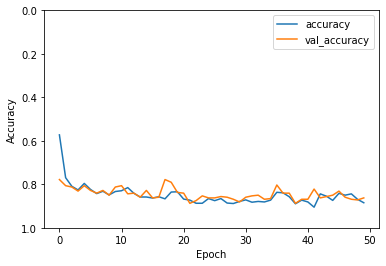

In [24]:
# plottig history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1, 0])
plt.legend(loc='upper right')
plt.show()

# Normal vs Glaucoma

In [ ]:
norm_glc = 'Data/norm vs glc'

In [8]:
# define image size and channels
IMG_SIZE = 224
CHANNELS = 3

BATCH_SIZE = 64

In [15]:
# increasing contrast and brightness
def contrast_only(img_np):
    img = tf.image.adjust_contrast(img_np, 2)
    img = tf.image.adjust_brightness(img, 0.5)
    return img

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
    preprocessing_function=contrast_only,
    validation_split = 0.3,
    rescale=1.0/255.0
)

In [17]:
# create training data
train_gen = train_datagen.flow_from_directory(
    directory=norm_glc,
    shuffle=True, 
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 897 images belonging to 2 classes.


In [18]:
# create training data
val_gen = train_datagen.flow_from_directory(
    directory=norm_glc,
    shuffle=True, 
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 383 images belonging to 2 classes.


### Create model

In [19]:
# define model
#layer 1
inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# shallow feature extraction layer
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(shallow)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(shallow)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Flatten()(shallow)
shallow = tf.keras.layers.Dense(64, activation='relu')(shallow)
shallow = tf.keras.layers.Dense(64, activation='relu')(shallow)

#layer 2
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 3
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 4
x = tf.keras.layers.Conv2D(128, (1, 1), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 5
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# flatten and add nueral layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x) # first dense layer
x = tf.keras.layers.Dense(128, activation='relu')(x) # second dense layer
x = tf.keras.layers.Dense(128, activation='relu')(x) # third dense layer
x = tf.keras.layers.Dense(64)(x) # fourth dense layer
sum_x = tf.keras.layers.add([x , shallow]) # adding shallow layer

output = tf.keras.layers.Dense(2, activation='sigmoid')(sum_x)

In [ ]:
# define & summarize model
model = tf.keras.Model(inputs, output)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics='accuracy')

Skipping the final activation layer and just getting the logits as these will be used for the final part of the assignment

In [ ]:
# train model
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.samples // BATCH_SIZE,
                    epochs= 50,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // BATCH_SIZE,)
                    #callbacks=[stop_train, accuracy_callback, lr_decay])

In [ ]:
model.save('models/glc_v1.h5')
model.save_weights('models/glc_1/')

In [ ]:
# plottig history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1, 0])
plt.legend(loc='upper right')
plt.show()

# Normal vs Other

In [ ]:
norm_oth = 'Data/norm vs other'

In [8]:
# define image size and channels
IMG_SIZE = 224
CHANNELS = 3

BATCH_SIZE = 64

In [15]:
# increasing contrast and brightness
def contrast(img_np):
    img = tf.image.adjust_contrast(img_np, 2)
    img = tf.image.adjust_brightness(img, 0.5)
    return img

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
    preprocessing_function=contrast,
    validation_split = 0.3,
    rescale=1.0/255.0
)

In [17]:
# create training data
train_gen = train_datagen.flow_from_directory(
    directory=norm_oth,
    shuffle=True, 
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 897 images belonging to 2 classes.


In [18]:
# create training data
val_gen = train_datagen.flow_from_directory(
    directory=norm_oth,
    shuffle=True, 
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 383 images belonging to 2 classes.


### Create model

In [19]:
# define model
#layer 1
inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# shallow feature extraction layer
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(shallow)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(shallow)
shallow = tf.keras.layers.MaxPooling2D((2, 2))(shallow)
shallow = tf.keras.layers.Flatten()(shallow)
shallow = tf.keras.layers.Dense(64, activation='relu')(shallow)
shallow = tf.keras.layers.Dense(64, activation='relu')(shallow)

#layer 2
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 3
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 4
x = tf.keras.layers.Conv2D(128, (1, 1), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#layer 5
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# flatten and add nueral layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x) # first dense layer
x = tf.keras.layers.Dense(128, activation='relu')(x) # second dense layer
x = tf.keras.layers.Dense(128, activation='relu')(x) # third dense layer
x = tf.keras.layers.Dense(64)(x) # fourth dense layer
sum_x = tf.keras.layers.add([x , shallow]) # adding shallow layer

output = tf.keras.layers.Dense(2, activation='sigmoid')(sum_x)

In [20]:
# define & summarize model
model = tf.keras.Model(inputs, output)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics='accuracy')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 222, 222, 256 7168        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 111, 111, 256 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 109, 109, 256 590080      max_pooling2d_8[0][0]            
_______________________________________________________________________________________

Skipping the final activation layer and just getting the logits as these will be used for the final part of the assignment

In [ ]:
# train model
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.samples // BATCH_SIZE,
                    epochs= 50,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // BATCH_SIZE,)
                    #callbacks=[stop_train, accuracy_callback, lr_decay])

In [ ]:
model.save('models/oth_v1.h5')
model.save_weights('models/oth_1/')

In [ ]:
# plottig history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1, 0])
plt.legend(loc='upper right')
plt.show()